<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/30_days_deep_learning_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5-5,损失函数losses
一般来说，监督学习的目标函数由损失函数和正则化项组成。（Objective = Loss + Regularization）

对于keras模型，目标函数中的正则化项一般在各层中指定，例如使用Dense的 kernel_regularizer 和 bias_regularizer等参数指定权重使用l1或者l2正则化项，此外还可以用kernel_constraint 和 bias_constraint等参数约束权重的取值范围，这也是一种正则化手段。

损失函数在模型编译时候指定。对于回归模型，通常使用的损失函数是均方损失函数 mean_squared_error。

对于二分类模型，通常使用的是二元交叉熵损失函数 binary_crossentropy。

对于多分类模型，如果label是one-hot编码的，则使用类别交叉熵损失函数 categorical_crossentropy。如果label是类别序号编码的，则需要使用稀疏类别交叉熵损失函数 sparse_categorical_crossentropy。

如果有需要，也可以自定义损失函数，自定义损失函数需要接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为损失函数值。




In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,losses,regularizers,constraints


In [4]:
#一，损失函数和正则化项
# tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(64,input_dim=64,kernel_regularizer=regularizers.l2(0.01),
                       activity_regularizer=regularizers.l1(0.01),
                       kernel_constraint=constraints.MaxNorm(max_value=2,axis=0)))
model.add(layers.Dense(10,kernel_regularizer=regularizers.l1_l2(0.01,0.01),activation="sigmoid"))
model.compile(optimizer = "rmsprop",
               loss = "binary_crossentropy",metrics=["AUC"])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 4,810
Trainable params: 4,810
Non-trainable params: 0
_________________________________________________________________


## 二，内置损失函数
内置的损失函数一般有类的实现和函数的实现两种形式。

如：CategoricalCrossentropy 和 categorical_crossentropy 都是类别交叉熵损失函数，前者是类的实现形式，后者是函数的实现形式。

常用的一些内置损失函数说明如下。

mean_squared_error（均方误差损失，用于回归，简写为 mse, 类与函数实现形式分别为 MeanSquaredError 和 MSE）

mean_absolute_error (平均绝对值误差损失，用于回归，简写为 mae, 类与函数实现形式分别为 MeanAbsoluteError 和 MAE)

mean_absolute_percentage_error (平均百分比误差损失，用于回归，简写为 mape, 类与函数实现形式分别为 MeanAbsolutePercentageError 和 MAPE)

Huber(Huber损失，只有类实现形式，用于回归，介于mse和mae之间，对异常值比较鲁棒，相对mse有一定的优势)[Huber loss](https://en.wikipedia.org/wiki/Huber_loss)

binary_crossentropy(二元交叉熵，用于二分类，类实现形式为 BinaryCrossentropy)

categorical_crossentropy(类别交叉熵，用于多分类，要求label为onehot编码，类实现形式为 CategoricalCrossentropy)

sparse_categorical_crossentropy(稀疏类别交叉熵，用于多分类，要求label为序号编码形式，类实现形式为 SparseCategoricalCrossentropy)

hinge(合页损失函数，用于二分类，最著名的应用是作为支持向量机SVM的损失函数，类实现形式为 Hinge)

kld(相对熵损失，也叫KL散度，常用于最大期望算法EM的损失函数，两个概率分布差异的一种信息度量。类与函数实现形式分别为 KLDivergence 或 KLD)

cosine_similarity(余弦相似度，可用于多分类，类实现形式为 CosineSimilarity)

## 自定义损失函数
自定义损失函数接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为损失函数值。

也可以对tf.keras.losses.Loss进行子类化，重写call方法实现损失的计算逻辑，从而得到损失函数的类的实现。

下面是一个Focal Loss的自定义实现示范。Focal Loss是一种对binary_crossentropy的改进损失函数形式。

它在样本不均衡和存在较多易分类的样本时相比binary_crossentropy具有明显的优势。

它有两个可调参数，alpha参数和gamma参数。其中alpha参数主要用于衰减负样本的权重，gamma参数主要用于衰减容易训练样本的权重。

从而让模型更加聚焦在正样本和困难样本上。这就是为什么这个损失函数叫做Focal Loss。

详见[《5分钟理解Focal Loss与GHM——解决样本不平衡利器》](https://zhuanlan.zhihu.com/p/80594704)

In [5]:
def focal_loss(gamma=2., alpha=0.75):
  def focal_loss_fixed(y_true,y_pred):
    bce = tf.losses.binary_crossentropy(y_true,y_pred)
    p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
    alpha_factor = y_true*alpha + (1-y_true)*(1-alpha)
    modulating_factor = tf.pow(1.0-p_t,gamma)
    loss = tf.reduce_sum(alpha_factor * modulating_factor * bce,axis = -1 )
    return loss

  return focal_loss_fixed

  


In [6]:
class FocalLoss(tf.keras.losses.Loss):
  def __init__(self,gamma=2.0,alpha=0.75,name="focal_loss"):
    self.gamma =gamma
    self.alpha = alpha

  def call(self,y_true,y_pred):
    bce = tf.losses.binary_crossentropy(y_true, y_pred)
    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
    alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
    modulating_factor = tf.pow(1.0 - p_t, self.gamma)
    loss = tf.reduce_sum(alpha_factor * modulating_factor * bce,axis = -1 )
    return loss

## 5-6,评估指标metrics
损失函数除了作为模型训练时候的优化目标，也能够作为模型好坏的一种评价指标。但通常人们还会从其它角度评估模型的好坏。

这就是评估指标。通常损失函数都可以作为评估指标，如MAE,MSE,CategoricalCrossentropy等也是常用的评估指标。 

但评估指标不一定可以作为损失函数，例如AUC（Area Under Curve）,Accuracy,Precision。因为评估指标不要求连续可导，而损失函数通常要求连续可导。

编译模型时，可以通过列表形式指定多个评估指标。

如果有需要，也可以自定义评估指标。

自定义评估指标需要接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为评估值。

也可以对tf.keras.metrics.Metric进行子类化，重写初始化方法, update_state方法, result方法实现评估指标的计算逻辑，从而得到评估指标的类的实现形式。

由于训练的过程通常是分批次训练的，而评估指标要跑完一个epoch才能够得到整体的指标结果。因此，类形式的评估指标更为常见。即需要编写初始化方法以创建与计算指标结果相关的一些中间变量，编写update_state方法在每个batch后更新相关中间变量的状态，编写result方法输出最终指标结果。

如果编写函数形式的评估指标，则只能取epoch中各个batch计算的评估指标结果的平均值作为整个epoch上的评估指标结果，这个结果通常会偏离整个epoch数据一次计算的结果。

## 一，常用的内置评估指标
MeanSquaredError（均方误差，用于回归，可以简写为MSE，函数形式为mse）

MeanAbsoluteError (平均绝对值误差，用于回归，可以简写为MAE，函数形式为mae)

MeanAbsolutePercentageError (平均百分比误差，用于回归，可以简写为MAPE，函数形式为mape)

RootMeanSquaredError (均方根误差，用于回归)

Accuracy (准确率，用于分类，可以用字符串"Accuracy"表示，Accuracy=(TP+TN)/(TP+TN+FP+FN)，要求y_true和y_pred都为类别序号编码)

Precision (精确率，用于二分类，Precision = TP/(TP+FP))

Recall (召回率，用于二分类，Recall = TP/(TP+FN))

TruePositives (真正例，用于二分类)

TrueNegatives (真负例，用于二分类)

FalsePositives (假正例，用于二分类)

FalseNegatives (假负例，用于二分类)

AUC(ROC曲线(TPR vs FPR)下的面积，用于二分类，直观解释为随机抽取一个正样本和一个负样本，正样本的预测值大于负样本的概率)

CategoricalAccuracy（分类准确率，与Accuracy含义相同，要求y_true(label)为onehot编码形式）

SparseCategoricalAccuracy (稀疏分类准确率，与Accuracy含义相同，要求y_true(label)为序号编码形式)

MeanIoU (Intersection-Over-Union，常用于图像分割)

TopKCategoricalAccuracy (多分类TopK准确率，要求y_true(label)为onehot编码形式)

SparseTopKCategoricalAccuracy (稀疏多分类TopK准确率，要求y_true(label)为序号编码形式)

Mean (平均值)

Sum (求和)

## 二， 自定义评估指标
我们以金融风控领域常用的KS指标为例，示范自定义评估指标。

KS指标适合二分类问题，其计算方式为 KS=max(TPR-FPR).

其中TPR=TP/(TP+FN) , FPR = FP/(FP+TN)

TPR曲线实际上就是正样本的累积分布曲线(CDF)，FPR曲线实际上就是负样本的累积分布曲线(CDF)。

KS指标就是正样本和负样本累积分布曲线差值的最大值。
KS(Kolmogorov-Smirnov)值衡量的是好坏样本累计分部之间的差值。
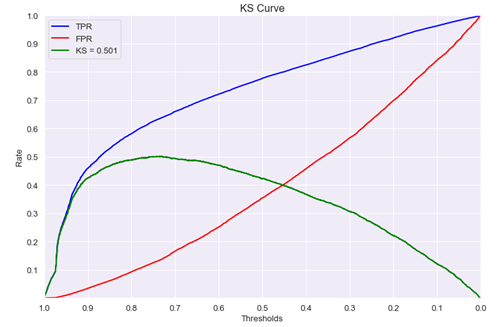

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,losses,metrics

In [11]:
#函数形式的自定义评估指标
@tf.function
def ks(y_true,y_pred):
    y_true = tf.reshape(y_true,(-1,))
    y_pred = tf.reshape(y_pred,(-1,))
    length = tf.shape(y_true)[0]
    t = tf.math.top_k(y_pred,k = length,sorted = False)
    y_pred_sorted = tf.gather(y_pred,t.indices)
    tf.print(y_pred_sorted)
    y_true_sorted = tf.gather(y_true,t.indices)
    tf.print(y_true_sorted)
    cum_positive_ratio = tf.truediv(tf.cumsum(y_true_sorted),tf.reduce_sum(y_true_sorted))
    tf.print(cum_positive_ratio)
    cum_negative_ratio = tf.truediv(tf.cumsum(1 - y_true_sorted),tf.reduce_sum(1 - y_true_sorted))
    tf.print(cum_negative_ratio)
    ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio)) 
    return ks_value

In [12]:
y_true = tf.constant([[1],[1],[1],[0],[1],[1],[1],[0],[0],[0],[1],[0],[1],[0]])
y_pred = tf.constant([[0.6],[0.1],[0.4],[0.5],[0.7],[0.7],[0.7],[0.4],[0.4],[0.5],[0.8],[0.3],[0.5],[0.3]])

tf.print(ks(y_true,y_pred))

[0.8 0.7 0.7 ... 0.3 0.3 0.1]
[1 1 1 ... 0 0 1]
[0.125 0.25 0.375 ... 0.875 0.875 1]
[0 0 0 ... 0.83333333333333337 1 1]
0.625


In [14]:
#类形式的自定义评估指标
class KS(metrics.Metric):
  def __init__(self, name = "ks", **kwargs):
    super(KS,self).__init__(name=name,**kwargs)
    self.true_positives = self.add_weight(name = "tp",shape = (101,), initializer = "zeros")
    self.false_positives = self.add_weight(name = "fp",shape = (101,), initializer = "zeros")

  @tf.function
  def update_state(self,y_true,y_pred):
    y_true = tf.cast(tf.reshape(y_true,(-1,)),tf.bool)
    y_pred = tf.cast(100*tf.reshape(y_pred,(-1,)),tf.int32)

    for i in tf.range(0,tf.shape(y_true)[0]):
      if y_true[i]:
        self.true_positives[y_pred[i]].assign(self.true_positives[y_pred[i]]+1.0)
      else:
        self.false_positives[y_pred[i]].assign(self.false_positives[y_pred[i]]+1.0)

    return (self.true_positives,self.false_positives)

  @tf.function
  def result(self):
    cum_positive_ratio = tf.truediv(tf.cumsum(self.true_positives),tf.reduce_sum(self.true_positives))
    cum_negative_ratio = tf.truediv(tf.cumsum(self.false_positives),tf.reduce_sum(self.false_positives))
    ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio)) 
    return ks_value




In [15]:
y_true = tf.constant([[1],[1],[1],[0],[1],[1],[1],[0],[0],[0],[1],[0],[1],[0]])
y_pred = tf.constant([[0.6],[0.1],[0.4],[0.5],[0.7],[0.7],
                      [0.7],[0.4],[0.4],[0.5],[0.8],[0.3],[0.5],[0.3]])

myks = KS()
myks.update_state(y_true,y_pred)
tf.print(myks.result())

0.625
